# Import libraries and packages

In [40]:
from generic.deep_learning_tools.signal_processing import TimeFrequencyTransformator
from generic.deep_learning_tools.peak_detector import PeakDetector
from generic.deep_learning_tools.figures import Plotter
from generic.deep_learning_tools.performance_metrics import EvaluationMetrics
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import pylab as plt
from sklearn.ensemble import RandomForestClassifier

# Explore Dataset

In [6]:
! tree UCI_HAR_Dataset/

UCI_HAR_Dataset/
├── activity_labels.txt
├── features_info.txt
├── features.txt
├── README.txt
├── test
│   ├── InertialSignals
│   │   ├── body_acc_x_test.txt
│   │   ├── body_acc_y_test.txt
│   │   ├── body_acc_z_test.txt
│   │   ├── body_gyro_x_test.txt
│   │   ├── body_gyro_y_test.txt
│   │   ├── body_gyro_z_test.txt
│   │   ├── total_acc_x_test.txt
│   │   ├── total_acc_y_test.txt
│   │   └── total_acc_z_test.txt
│   ├── subject_test.txt
│   ├── X_test.txt
│   └── y_test.txt
└── train
    ├── InertialSignals
    │   ├── body_acc_x_train.txt
    │   ├── body_acc_y_train.txt
    │   ├── body_acc_z_train.txt
    │   ├── body_gyro_x_train.txt
    │   ├── body_gyro_y_train.txt
    │   ├── body_gyro_z_train.txt
    │   ├── total_acc_x_train.txt
    │   ├── total_acc_y_train.txt
    │   └── total_acc_z_train.txt
    ├── subject_train.txt
    ├── X_train.txt
    └── y_train.txt

4 directories, 28 files


In [7]:
cat UCI_HAR_Dataset/README.txt

Human Activity Recognition Using Smartphones Dataset
Version 1.0
Jorge L. Reyes-Ortiz(1,2), Davide Anguita(1), Alessandro Ghio(1), Luca Oneto(1) and Xavier Parra(2)
1 - Smartlab - Non-Linear Complex Systems Laboratory
DITEN - Universit�  degli Studi di Genova, Genoa (I-16145), Italy. 
2 - CETpD - Technical Research Centre for Dependency Care and Autonomous Living
Universitat Polit�cnica de Catalunya (BarcelonaTech). Vilanova i la Geltr� (08800), Spain
activityrecognition '@' smartlab.ws 

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained data

The dataset is already splitted into a training and a test part, so we can immediately load the signals into an numpy ndarray. Each component has been saved in a separate txt.

# Load training and testing labels

In [8]:
directory = 'UCI_HAR_Dataset/'

train_labels_path = directory + 'train/' + 'y_train.txt'
test_labels_path = directory + 'test/' + 'y_test.txt'

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)

y_train = read_labels(train_labels_path)
y_test = read_labels(test_labels_path)

# Dataset distribution 

In [9]:
cat UCI_HAR_Dataset/activity_labels.txt

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


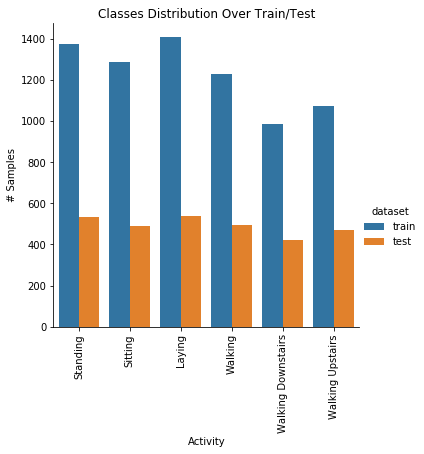

In [10]:
activity_labels = dict({1:'Walking', 2:'Walking Upstairs', 3:'Walking Downstairs', 4:'Sitting', 5:'Standing', 6:'Laying'})

train_data = pd.DataFrame(y_train, columns=['Activity'])
train_data['dataset'] = 'train'
test_data = pd.DataFrame(y_test, columns=['Activity'])
test_data['dataset'] = 'test'
data = pd.concat([train_data, test_data])
data['Activity'] = data['Activity'].apply(lambda x: activity_labels[x])

sns.catplot(x='Activity', hue='dataset', kind='count', data=data)
plt.xticks(rotation=90)
plt.ylabel('# Samples')
_ = plt.title('Classes Distribution Over Train/Test')

It is likely safe to work with the dataset as the distribution of classes is balanced per train and test set and perhaps per subject.

In [11]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/InertialSignals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    print('{} Data is made of: {} signals with {} components with {} samples each.'.format(group.upper(), X.shape[0], X.shape[2], X.shape[1]))
    return X
 
# load all train
X_train = load_dataset('train', directory)
X_test = load_dataset('test', directory)

TRAIN Data is made of: 7352 signals with 9 components with 128 samples each.
TEST Data is made of: 2947 signals with 9 components with 128 samples each.


# Build new features from the components

We visualize the signal itself with its nine components, the FFT, the PSD and auto-correlation of the components, together with the peaks present in each of the three transformations.

In [12]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']

 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']]

time_frequency_transformator = TimeFrequencyTransformator(frequency=50, n_samples=128, t_n=2.56)

functions = [time_frequency_transformator.get_values, time_frequency_transformator.get_psd_values, time_frequency_transformator.get_fft_values, time_frequency_transformator.get_autocorr_values]

Below, we will visualize the signal itself with its nine components, the FFT, the PSD and auto-correlation of the components, together with the peaks present in each of the three transformations.

/home/virginie/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


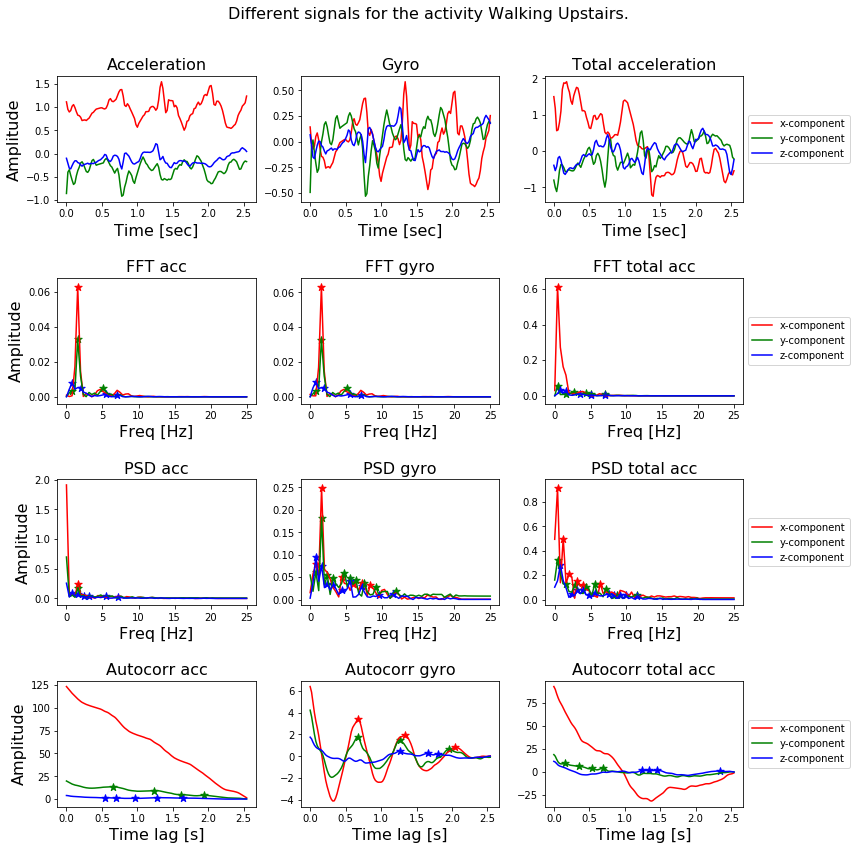

In [13]:
signal_no = 500
signals = X_train[signal_no, :, :]
label = y_train[signal_no]
activity_name = activity_labels[label]
suptitle = 'Different signals for the activity {}.'.format(activity_name)
f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle, fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = PeakDetector().detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)

In [14]:
def get_first_n_peaks(x,y,n_peaks):
    if len(x) >= n_peaks:
        return x[:n_peaks], y[:n_peaks]
    else:
        missing_n_peaks = n_peaks-len(x) # Pad with 0
        return np.append(x, [0]*missing_n_peaks), np.append(y, [0]*missing_n_peaks)
    
def get_features(x_values, y_values, mph, n_peaks):
    indices_peaks = PeakDetector().detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks], n_peaks)
    return np.append(peaks_x, peaks_y)

def get_minimum_peak_distance(signal, percentile, denominator):
    """
    This method can be applied to any signal, whether the signal is a time-dependent signal or a frequency-dependent signal. 
    I am simply disregarding any peaks below a certain percentage of the maximum amplitude in the signal, since they are more likely 
    to be the result of noise than actual information.
    """
    min_signal_amplitude = np.nanpercentile(signal, percentile)
    max_signal_amplitude = np.nanpercentile(signal, 100-percentile)
    return min_signal_amplitude + (max_signal_amplitude - min_signal_amplitude)/denominator
 
def augment_features(features, functions, denominator, percentile, n_peaks):
    features_collection = []
    n_signals, n_samples, n_components = features.shape
    
    for signal_no in range(n_signals):
        augmented_features = []
        for signal_comp in range(n_components):            
            signal = features[signal_no, :, signal_comp]
            minimum_peak_distance = get_minimum_peak_distance(signal, percentile, denominator)
            
            for function in functions:
                x_values, y_values = function(signal)
                augmented_features += list(get_features(x_values, y_values, minimum_peak_distance, n_peaks))
        features_collection.append(augmented_features)
    features = np.array(features_collection)
    print('Data is made of: {} signals with {} features each.'.format(features.shape[0], features.shape[1]))
    return features
 
denominator = 10
percentile = 5
n_peaks = 5
functions = functions[1:]
X_augmented_train = augment_features(X_train, functions, denominator, percentile, n_peaks)
X_augmented_test = augment_features(X_test, functions, denominator, percentile, n_peaks)

/home/virginie/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


Data is made of: 7352 signals with 270 features each.
Data is made of: 2947 signals with 270 features each.


This process results in a matrix containing the features of the training set, and a matrix containing the features of the test set. The number rows of these matrices should be equal to the number of signals in each set 
(7352 and 2947). The number of columns in each matrix depend on depends on your choice of features. Each signal has nine components, and for each component you can calculate either just the FFT or all 
three of the transformations. For each transformation you can decide to look at the first n peaks in the signal. And for each peak you can decide to take only the x value, or both the x and y values. In the 
example above, we have taken the x and y values of the first 5 peaks of each transform, so we have 270 columns (9 * 3 * 5 * 2) in total.

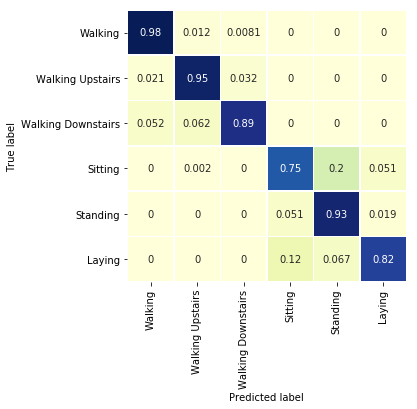

In [39]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_augmented_train, y_train)
y_pred = clf.predict(X_augmented_test)

normalised_confusion_matrix = EvaluationMetrics().normalised_confusion_matrix(y_test, y_pred)
ticklabels = [item[1] for item in activity_labels.items()]
_ = Plotter().plot_confusion_matrix(normalised_confusion_matrix, ticklabels, (5,5))

As you can see, we were able to classify these signals with quite a high accuracy.

The feature selection was done fully automatic; for each transformation we selected the x and y component of the first five peaks (or use the default value of zero).

It is understandable that some of the 270 features will be more informative than other ones. It could be that some transformations of some components do not have five peaks, or that the frequency value of the peaks is more informative than the amplitude value, or that the FFT is always more informative than the auto-correlation.

The accuracy will increase even more if we actively select the features, transformations and components which are important for classification. Maybe we can even choose a different classifier or play around with its parameter values (hyperparameter optimization) to achieve a higher accuracy.